In [33]:
import sys
import time
import math

sys.path.append("../attachments/repo")

from lib.data.dataplot import *
from lib.utils.time import *
from lib.utils.geometry import *
from lib.system.cart import *
from lib.system.basic import *
from lib.system.controllers import *
from lib.system.trajectory import *

In [67]:
class System:
	def __init__(self, x, y, r, theta):
		self.x = x
		self.y = y
		self.r = r
		self.theta = theta
	
	def evaluate(self, delta_t, _input):
		new_x2 = (1 - 0.5 * delta_t) * self.x2 - 4 * self.x1 * delta_t + 3 * _input * delta_t
		self.x1 = self.x2 * delta_t + self.x1

		self.x2 = new_x2
		return self.x1

class StraightToCirconferenceSystem:
	def __init__(self, r):
		self.r = r

	def evaluate(self, delta_t, _input):
		angle = _input / self.r
		x = self.r * math.cos(angle)
		y = self.r * math.sin(angle)

		return x, y

class CirconferenceRobot():
	def __init__(self, r_x, r_y, r, theta, vr_params = [10, 3, 3]):
		self.r_x = r_x
		self.r_y = r_y
		self.r = r
		self.theta = theta

		self.vr = VirtualRobot(r*theta, *vr_params)
		self.stc = StraightToCirconferenceSystem(r)

		self.real_pos = 0, 0
	
	def evaluate(self, delta_t):
		
		self.vr.evaluate(delta_t)
		p = self.vr.position()

		self.real_pos = x1, y1 = self.stc.evaluate(delta_t, p)

		x2, y2 = rototranslate(x1, y1, 0, self.r, -math.pi / 2)
		x3, y3 = rototranslate(x2, y2, self.r_x, self.r_y, self.theta)

		return x2, y2
	
	def get_real_position():
		return self.real_pos

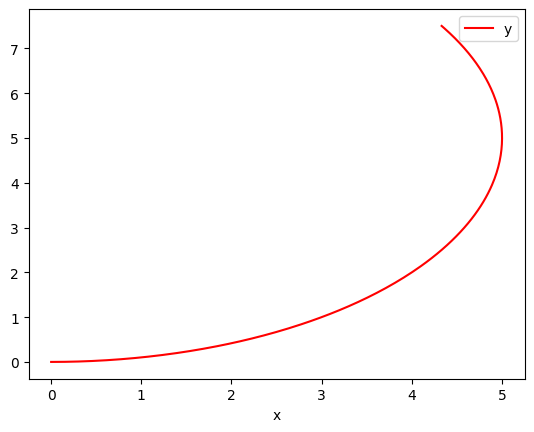

In [68]:
dp = DataPlotter()
dp.set_x("x")
dp.add_y("y","y")

r_x, r_y = 10, 20
r, theta = 5, math.pi * 2/3

system = CirconferenceRobot(r_x, r_y, r, theta)

delta_t = 0.01
t = 0
while t < 7:
    
    x, y = system.evaluate(delta_t)
    dp.append_x(x)
    dp.append_y("y", y)

    t += delta_t

dp.plot()

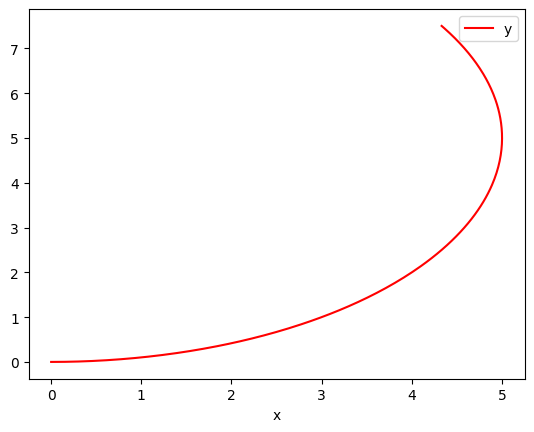

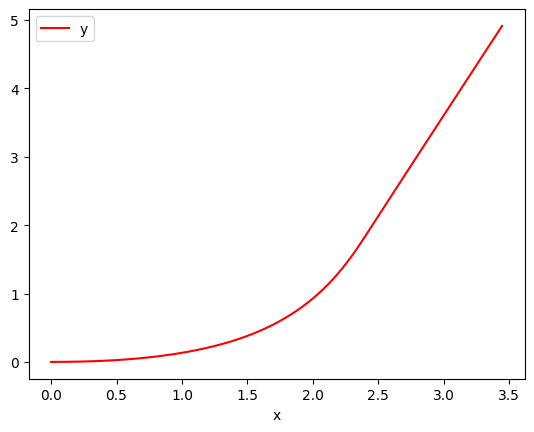

In [69]:
import sys
sys.path.append("../../")

#
# TO BE USED WITH godot/card2D_no_physics
#

from lib.data.dataplot import *
from lib.system.cart import *
from lib.system.controllers import *
from lib.system.trajectory import *
from lib.system.polar import *
from lib.dds.dds import *
from lib.utils.time import *

class SpeedControl2D:
    
    def __init__(self, _lin_params, _rot_params):
        """
        Construct a speed controller for a 2D robot.
        :params _lin_params: an array specifying [kp, ki, kd, Sat(Optional)] for linear controller
        :params _rot_params: an array specifying [kp, ki, kd, Sat(Optional)] for angular controller
        """
        self.linear_controller = PID_Controller(*_lin_params)
        self.rotation_controller = PID_Controller(*_rot_params)
        self.v_target = 0
        self.w_target = 0
    
    def set_v_target(self, v):
        self.v_target = v
        
    def set_w_target(self, w):
        self.w_target = w
        
    def set_targets(self, v, w):
        self.v_target = v
        self.w_target = w
        
    def evaluate(self, delta_t, v_current, w_current):
        v_error = self.v_target - v_current
        f_out = self.linear_controller.evaluate(delta_t, v_error)
        
        w_error = self.w_target - w_current
        t_out = self.rotation_controller.evaluate(delta_t, w_error)
        
        return (f_out, t_out)

tdp = DataPlotter()
tdp.set_x("x")
tdp.add_y("y","y")

dpv = DataPlotter()
dpv.set_x("x")
dpv.add_y("y","y")


cart2d = Cart2D(1.0, 0.3, 0.9, 0.8)

speed_ctrl = SpeedControl2D([30.0, 6.0, 0.0], # parameters for linear speed controller
                            [4.0, 8.0, 0.0]) # parameters for angular speed controller

polar_position = Polar2DController(4, 1.0, # kp = 4, vmax = 1 m/s
                                   8, 6.0) # kp = 8, wmax = 6 rad/s


virtual_robot = CirconferenceRobot(r_x, r_y, r, theta)

pose = cart2d.get_pose()

delta_t = 0.01
t = 0
while t < 7:

    (x_target, y_target) = virtual_robot.evaluate(delta_t)
    
    pose = cart2d.get_pose()
    (v_target, w_target) = polar_position.evaluate(delta_t, x_target, y_target, pose)
    
    (v, w) = cart2d.get_speed()
    
    speed_ctrl.set_targets(v_target, w_target)
    (force, torque) = speed_ctrl.evaluate(delta_t, v, w)
    
    cart2d.evaluate(delta_t, force, torque)
    
    dpv.append_x(x_target)
    dpv.append_y("y", y_target)


    tdp.append_x(pose[0])
    tdp.append_y("y", pose[1])

    t += delta_t
    
dpv.plot()
tdp.plot()
